In [71]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

In [50]:
# Import train data
ne_train = pd.read_csv("../../data/ne_train.csv")
s_train = pd.read_csv("../../data/s_train.csv")

# Import test data
ne_test = pd.read_csv("../../data/ne_test.csv")
s_test = pd.read_csv("../../data/s_test.csv")

In [51]:
ne_col = ["num__lagged_covid_19_confirmed_cases_15",
         "num__lagged_covid_19_confirmed_cases_45",
         "num__rolling_covid_19_confirmed_cases_15",
         "num__rolling_covid_19_confirmed_cases_30",
         "num__rolling_covid_19_confirmed_cases_45",
         "num__daily_state_test",
         "num__temperature",
         "num__precipitation",
         "cat__social_distancing_travel_distance_grade_F",
         "cat__social_distancing_encounters_grade_A",
         "cat__social_distancing_encounters_grade_F",
         "cat__social_distancing_total_grade_F"]

In [52]:
s_col = ["num__lagged_covid_19_confirmed_cases_15",
        "num__lagged_covid_19_confirmed_cases_30",
        "num__lagged_covid_19_confirmed_cases_45",
        "num__rolling_covid_19_confirmed_cases_15",
        "num__rolling_covid_19_confirmed_cases_30",
        "num__rolling_covid_19_confirmed_cases_45",
        "num__daily_state_test"]

In [53]:
ne_X_train = ne_train.loc[:, ne_col]
ne_y_train = ne_train.covid_19_confirmed_cases

In [54]:
s_X_train = s_train.loc[:, s_col]
s_y_train = s_train.covid_19_confirmed_cases

In [55]:
ne_X_test = ne_test.loc[:, ne_col]
ne_y_test = ne_test.covid_19_confirmed_cases

In [56]:
s_X_test = s_test.loc[:, s_col]
s_y_test = s_test.covid_19_confirmed_cases

# XgBoost Model
- Ensemble of decision trees algorithm where new trees fix errors of those trees that are already part of the model
    - Trees are added until no further improvements can be made to the model

## Baseline Model
- NE: MAE on test data = 1210 confirmed cases
    - 5 features were not significant compared to others
        - num__rolling_covid_19_confirmed_cases_30
        - num__rolling_covid_19_confirmed_cases_45
        - cat__social_distancing_encounters_grade_A
        - cat__social_distancing_total_grade_F
        - cat__social_distancing_travel_distance_grade_F
    - Categorical features were all not important
- S: MAE on test data = 10122 confirmed cases
    - 2 features were not significant compared to others
        - num__rolling_covid_19_confirmed_cases_30
        - num__rolling_covid_19_confirmed_cases_45

### NE Region

In [57]:
ne_model = xgb.XGBRegressor(n_estimators=1000)
ne_model.fit(ne_X_train, ne_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

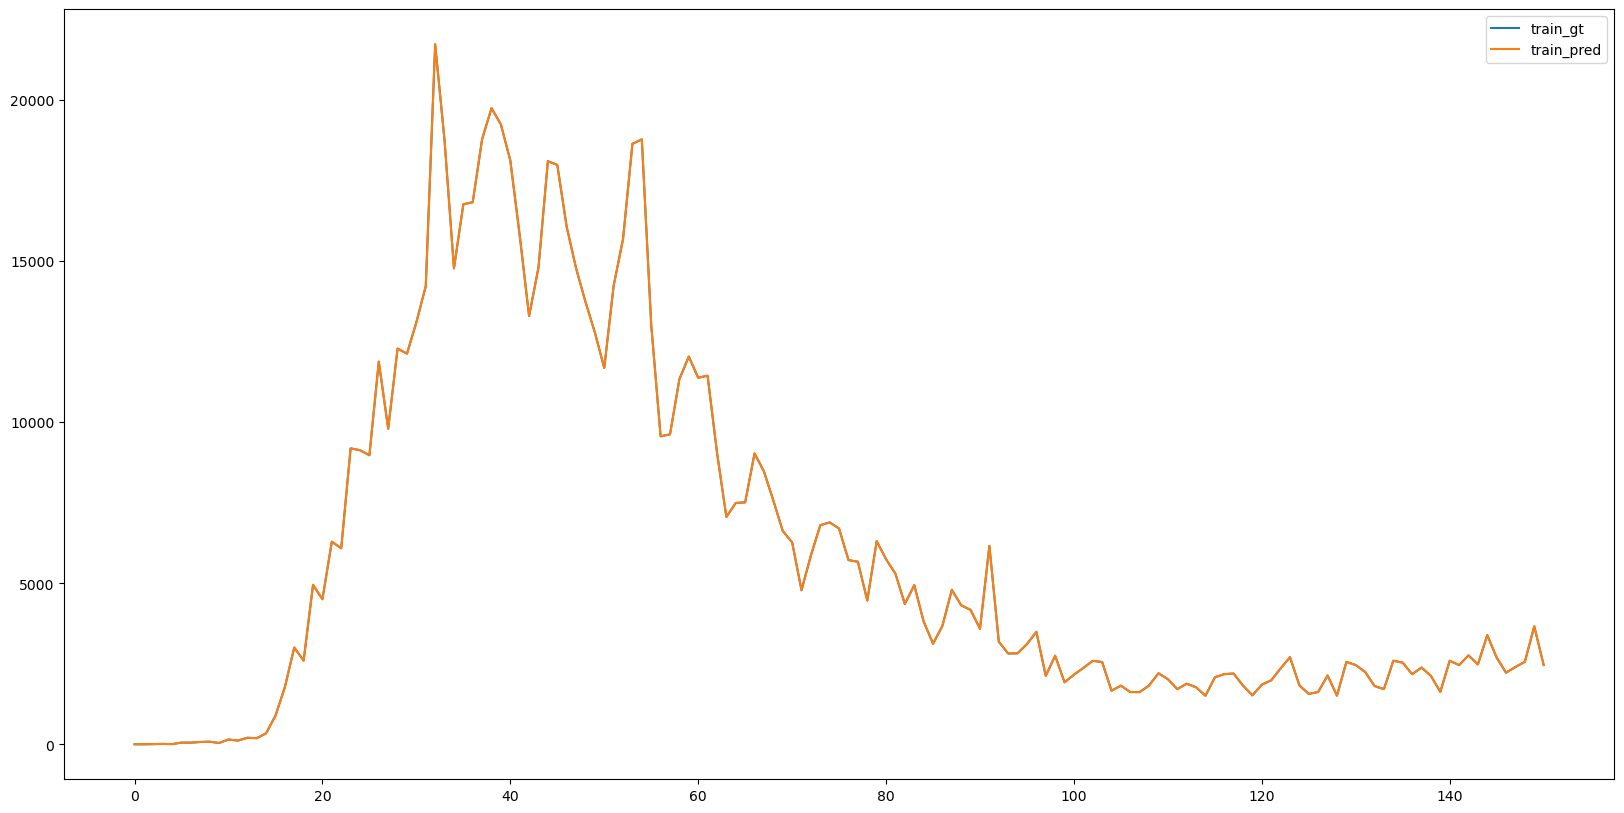

In [58]:
# Visualizing train data fitted values
ne_train_pred = pd.DataFrame(ne_model.predict(ne_X_train), columns=['yhat'], index=ne_X_train.index)
pd.concat([ne_y_train, ne_train_pred["yhat"]], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [59]:
ne_test_pred = pd.DataFrame(ne_model.predict(ne_X_test), columns=['yhat'], index=ne_X_test.index)

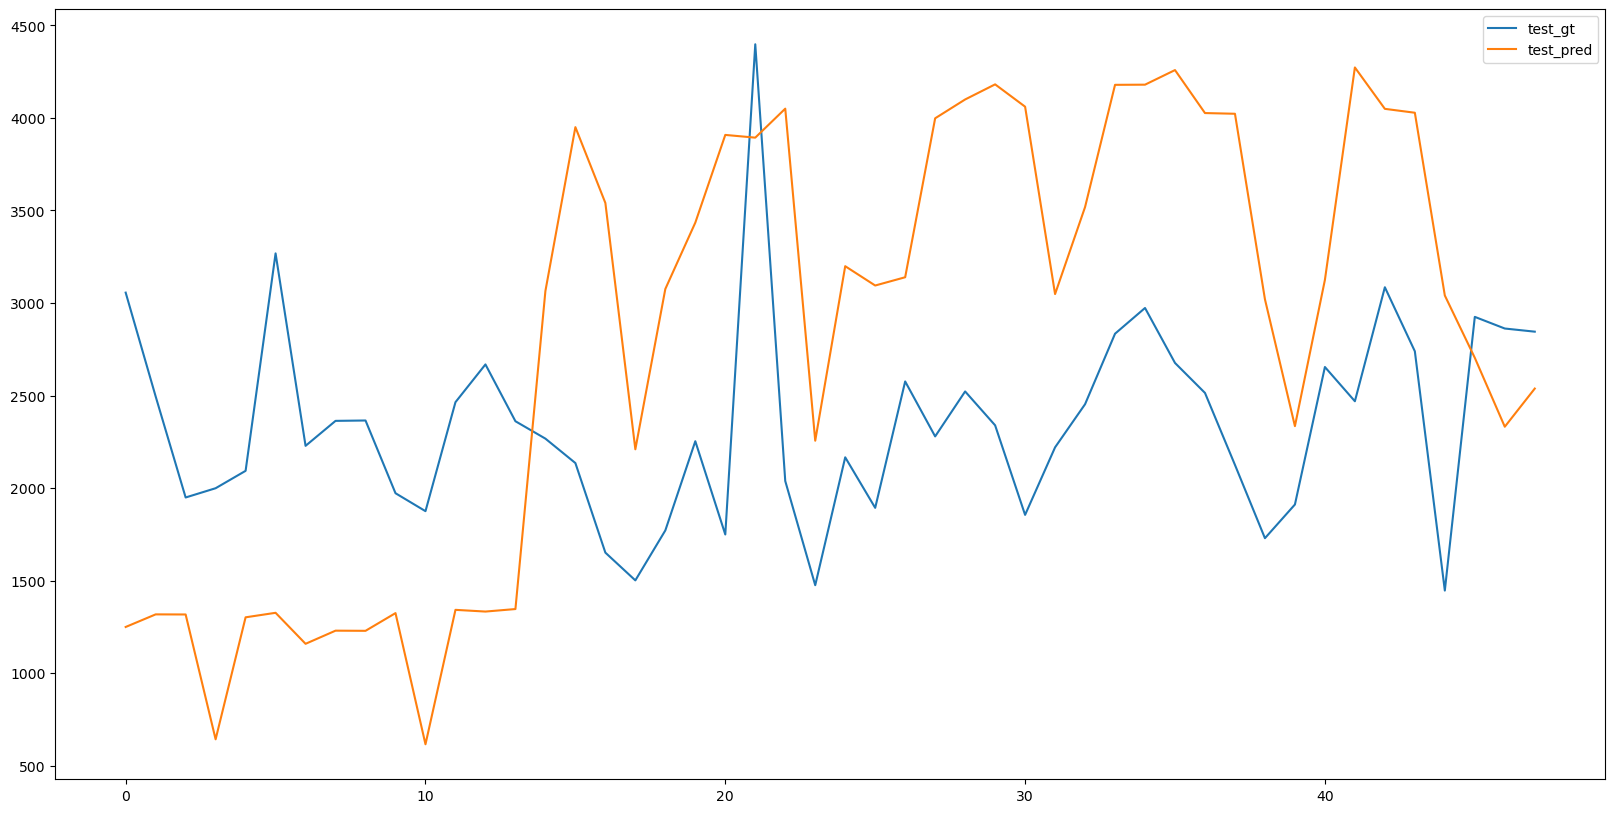

In [60]:
# Visualizing test data fitted values
pd.concat([ne_y_test, ne_test_pred["yhat"]], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [61]:
# MAE on test data
mean_absolute_error(ne_y_test, ne_test_pred)

1209.5118459065754

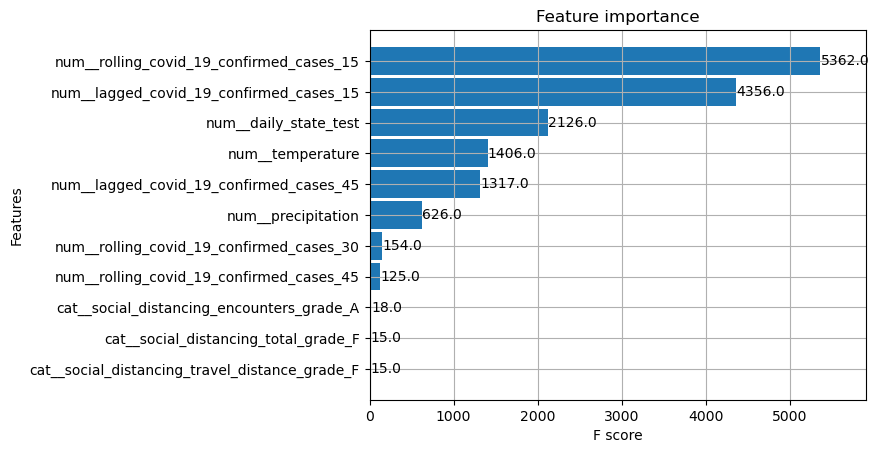

In [62]:
# Feature importance
ne_feature_im = plot_importance(ne_model, height=0.9)

### S Region

In [63]:
s_model = xgb.XGBRegressor(n_estimators=1000)
s_model.fit(s_X_train, s_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

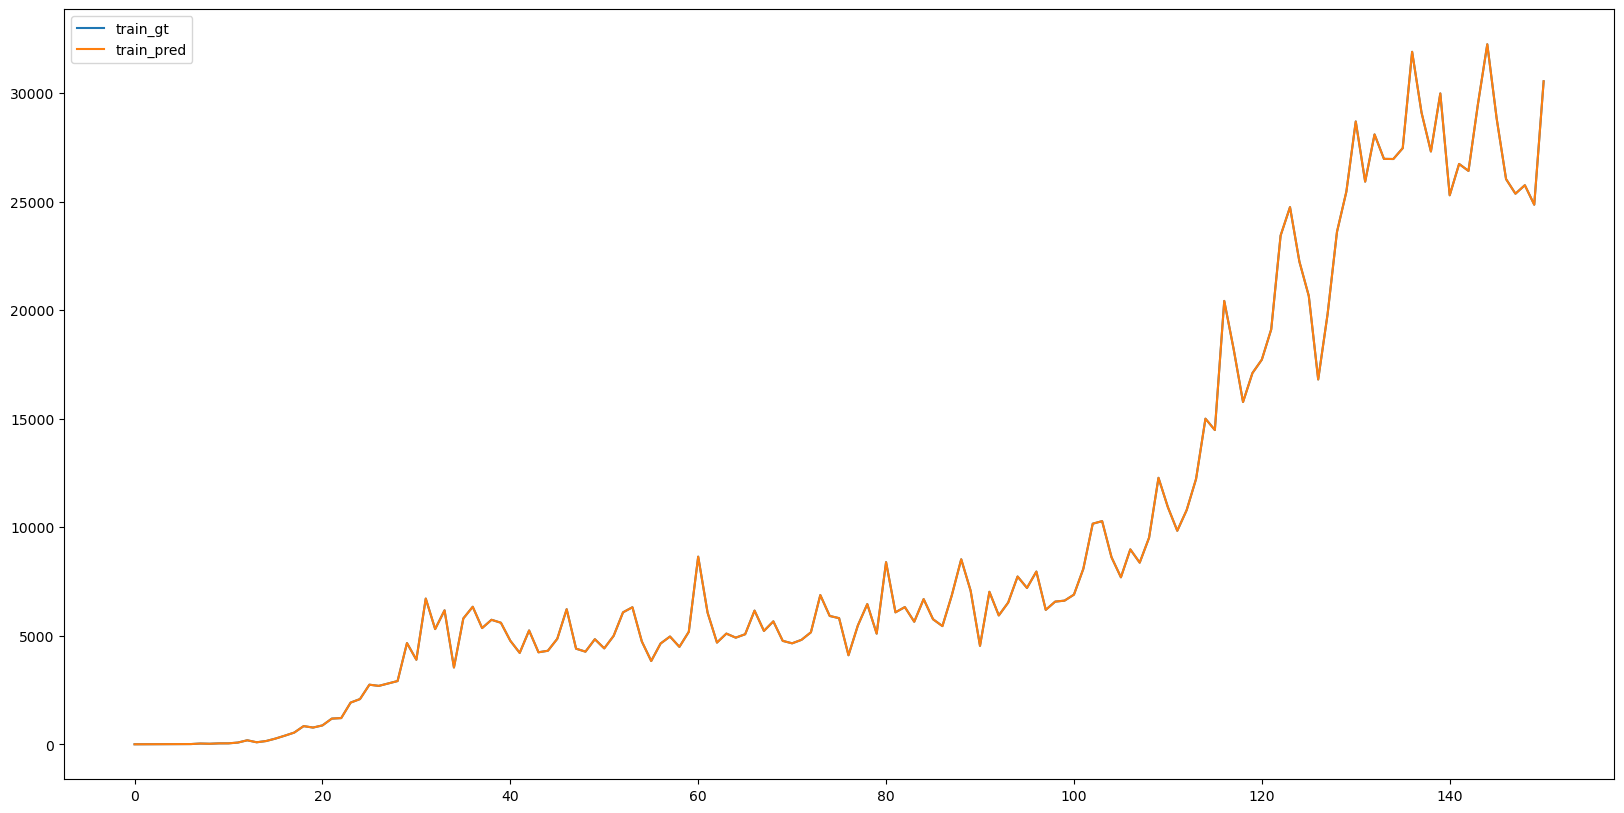

In [64]:
# Visualizing train data fitted values
s_train_pred = pd.DataFrame(s_model.predict(s_X_train), columns=['yhat'], index=s_X_train.index)
pd.concat([s_y_train, s_train_pred["yhat"]], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [65]:
s_test_pred = pd.DataFrame(s_model.predict(s_X_test), columns=['yhat'], index=s_X_test.index)

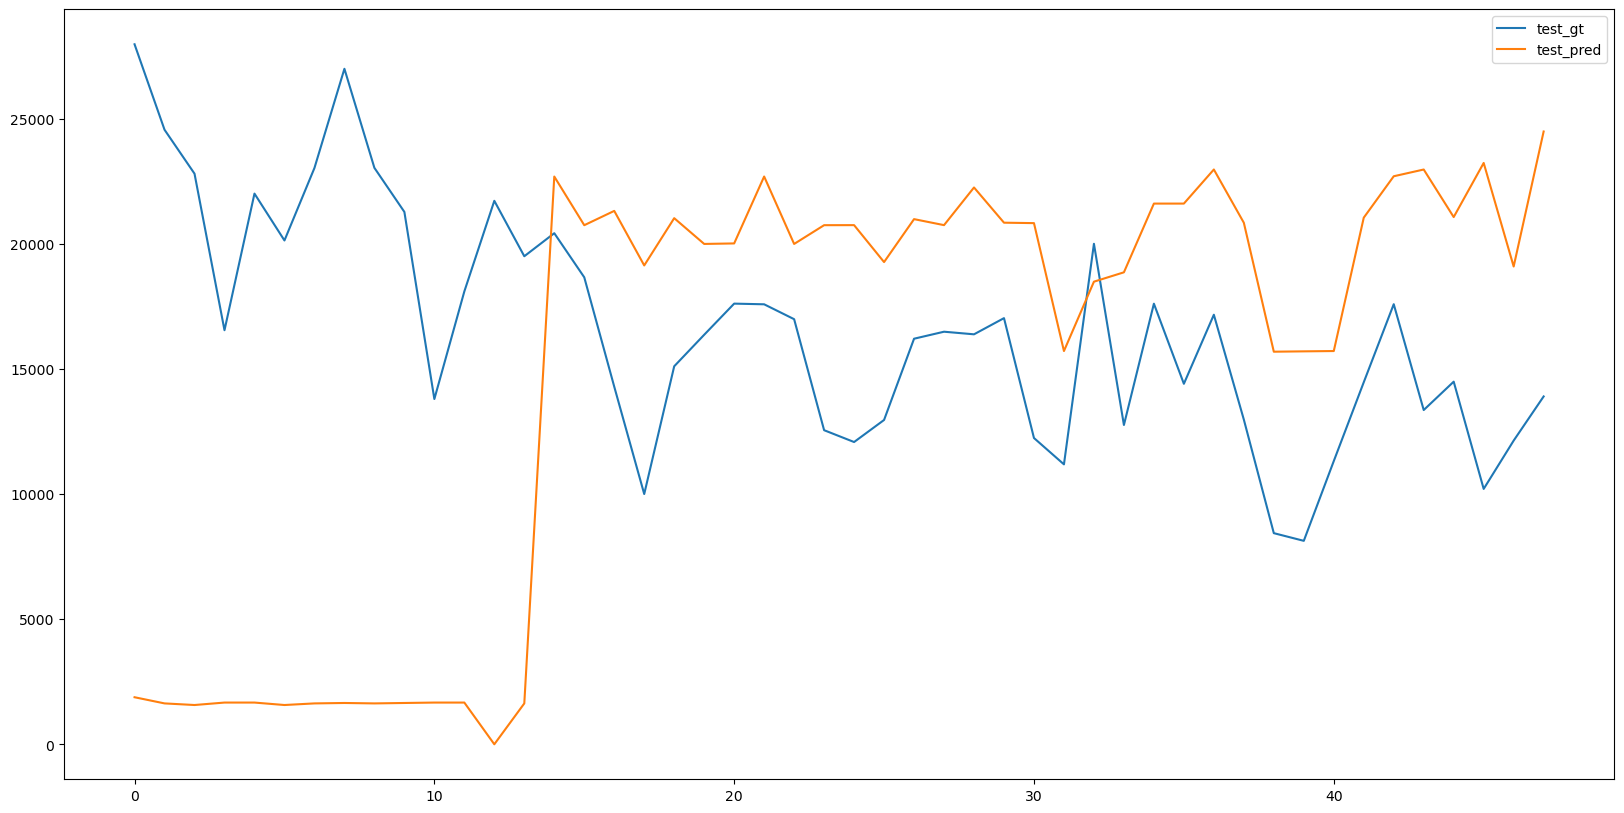

In [66]:
# Visualizing test data fitted values
pd.concat([s_y_test, s_test_pred["yhat"]], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [67]:
# MAE on test data
mean_absolute_error(s_y_test, s_test_pred)

10122.258509630958

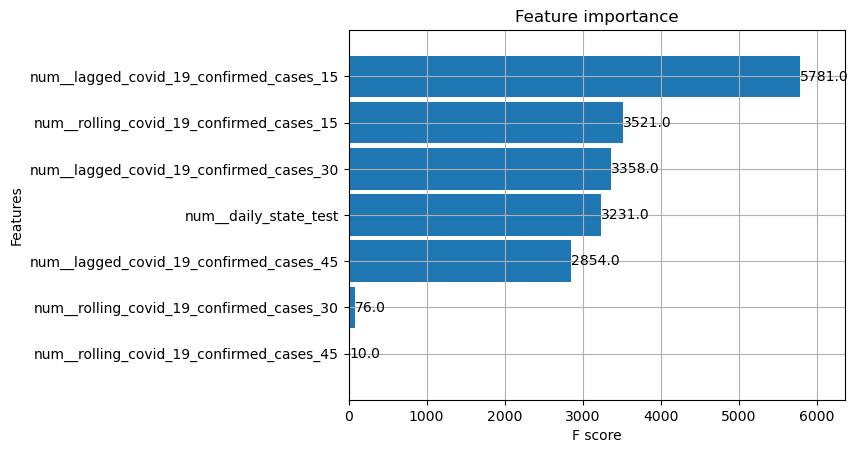

In [68]:
# Feature importance
s_feature_im = plot_importance(s_model, height=0.9)

## Tuned model
- GridsearchCV + Time series split
- Early stopping!
- NE: MAE on test data = 444 confirmed cases
    - Better than ARIMA but worse than Auto-ARIMA
- S: MAE on test data = 5666 confirmed cases
    - Better than ARIMA but worse than Auto-ARIMA

### NE Region

In [368]:
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0,3],
    "n_estimators": [500, 1000],
    "max_depth": [3, 4, 6, 5, 10],
    "min_child_weight": [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_lambda": [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    "reg_alpha":[0, 0.001, 0.005, 0.01, 0.05],
    "gamma": [0, 0.25, 0.5, 1.0],
}

In [376]:
cv_split = TimeSeriesSplit(n_splits=4)
ne_model = xgb.XGBRegressor()
ne_randomized_search = RandomizedSearchCV(ne_model, 
                                          param_grid, 
                                          cv=cv_split,
                                         n_iter = 50)

In [377]:
ne_randomized_search.fit(ne_X_train, ne_y_train,
                         early_stopping_rounds=40,
                        verbose = False,
                        eval_set=[(ne_X_train, ne_y_train), (ne_X_test, ne_y_test)])

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0, 3],
                                        'max_depth': [3, 4, 6, 5, 10],
                                        'min_child_weight': [0.5, 1.0, 3.0, 5.0,
                                                             7.0, 10.0],
                                        'n_estimators': [500, 1000],
                                        'reg_alpha': [0, 0.001, 0.005, 0.01,
                                                      0.05],
                                        'reg_lambda': [0.1, 1.0, 5.0, 10.0,
                                                       50.0, 100.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]})

In [378]:
# Optimal params
ne_randomized_search.best_params_

{'subsample': 0.5,
 'reg_lambda': 10.0,
 'reg_alpha': 0.005,
 'n_estimators': 1000,
 'min_child_weight': 7.0,
 'max_depth': 3,
 'learning_rate': 0.2,
 'gamma': 1.0,
 'colsample_bytree': 0.9}

In [379]:
ne_test_pred = pd.DataFrame(ne_randomized_search.predict(ne_X_test), columns=['yhat'], index=ne_X_test.index)

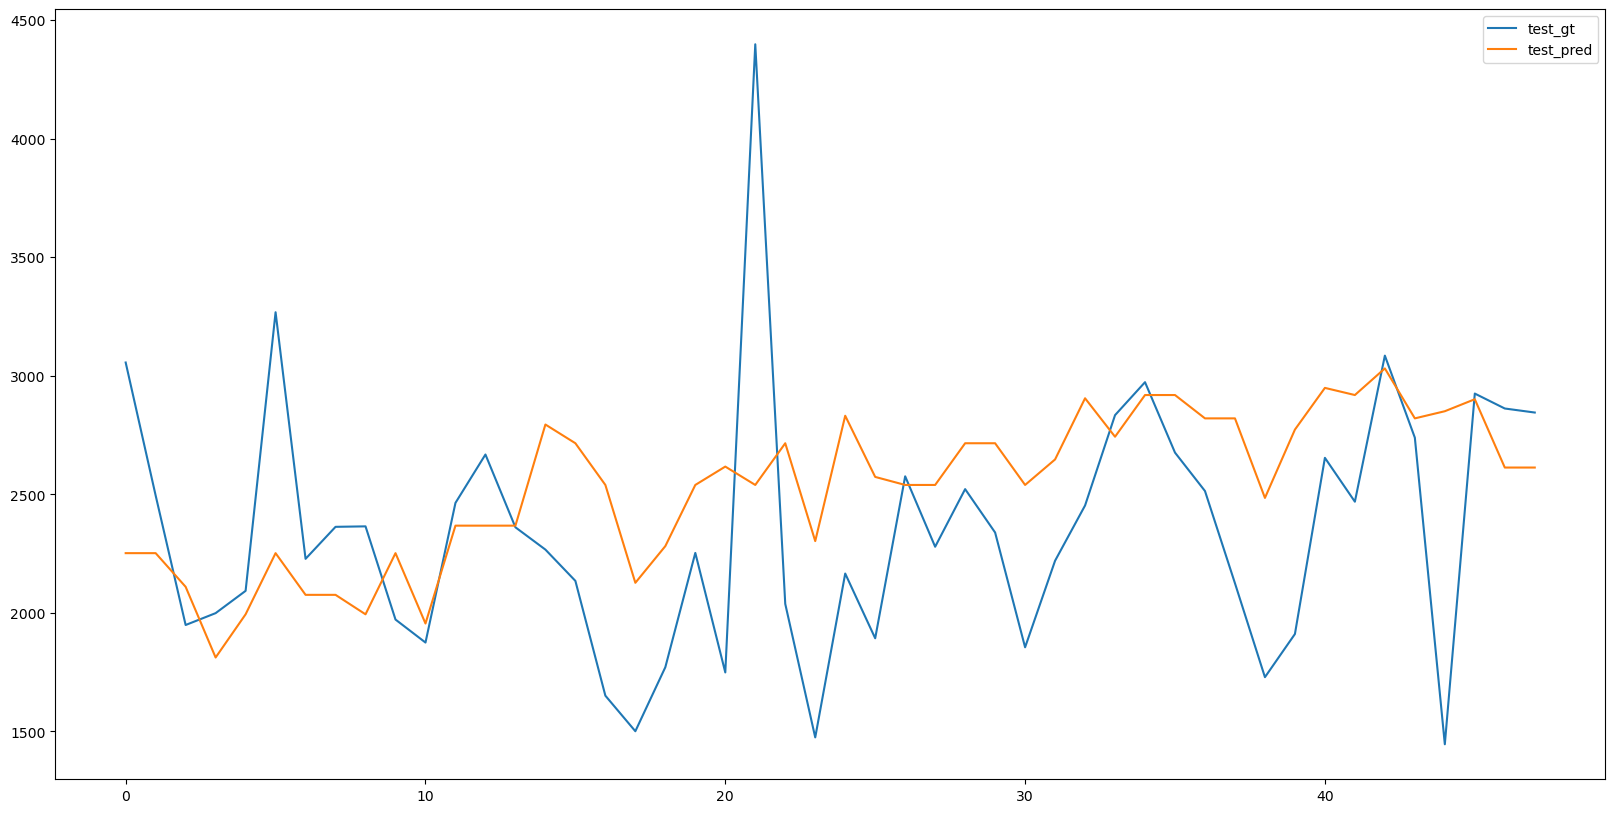

In [380]:
# Visualizing test data fitted values
pd.concat([ne_y_test, ne_test_pred["yhat"]], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [381]:
# MAE on test data
mean_absolute_error(ne_y_test, ne_test_pred)

443.93126678466797

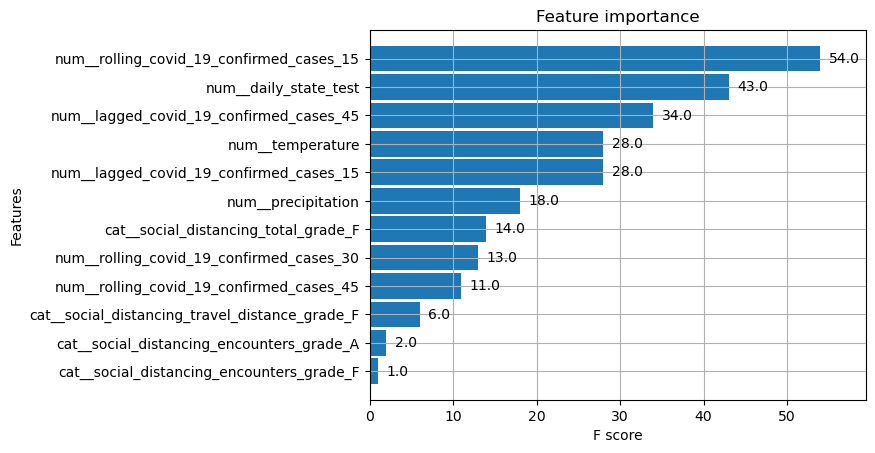

In [382]:
# Feature importance
ne_feature_im = plot_importance(ne_randomized_search.best_estimator_, height=0.9)

### S Region

In [446]:
cv_split = TimeSeriesSplit(n_splits=4)
s_model = xgb.XGBRegressor()
s_randomized_search = RandomizedSearchCV(s_model, 
                                          param_grid, 
                                          cv=cv_split,
                                         n_iter = 50)

In [447]:
s_randomized_search.fit(s_X_train, s_y_train,
                         early_stopping_rounds=40,
                        verbose = False,
                        eval_set=[(s_X_train, s_y_train), (s_X_test, s_y_test)])

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0, 3],
                                        'max_depth': [3, 4, 6, 5, 10],
                                        'min_child_weight': [0.5, 1.0, 3.0, 5.0,
                                                             7.0, 10.0],
                                        'n_estimators': [500, 1000],
                                        'reg_alpha': [0, 0.001, 0.005, 0.01,
                                                      0.05],
                                        'reg_lambda': [0.1, 1.0, 5.0, 10.0,
                                                       50.0, 100.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]})

In [448]:
# Optimal params
s_randomized_search.best_params_

{'subsample': 0.5,
 'reg_lambda': 1.0,
 'reg_alpha': 0.005,
 'n_estimators': 1000,
 'min_child_weight': 5.0,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.5,
 'colsample_bytree': 0.7}

In [449]:
s_test_pred = pd.DataFrame(s_randomized_search.predict(s_X_test), columns=['yhat'], index=s_X_test.index)

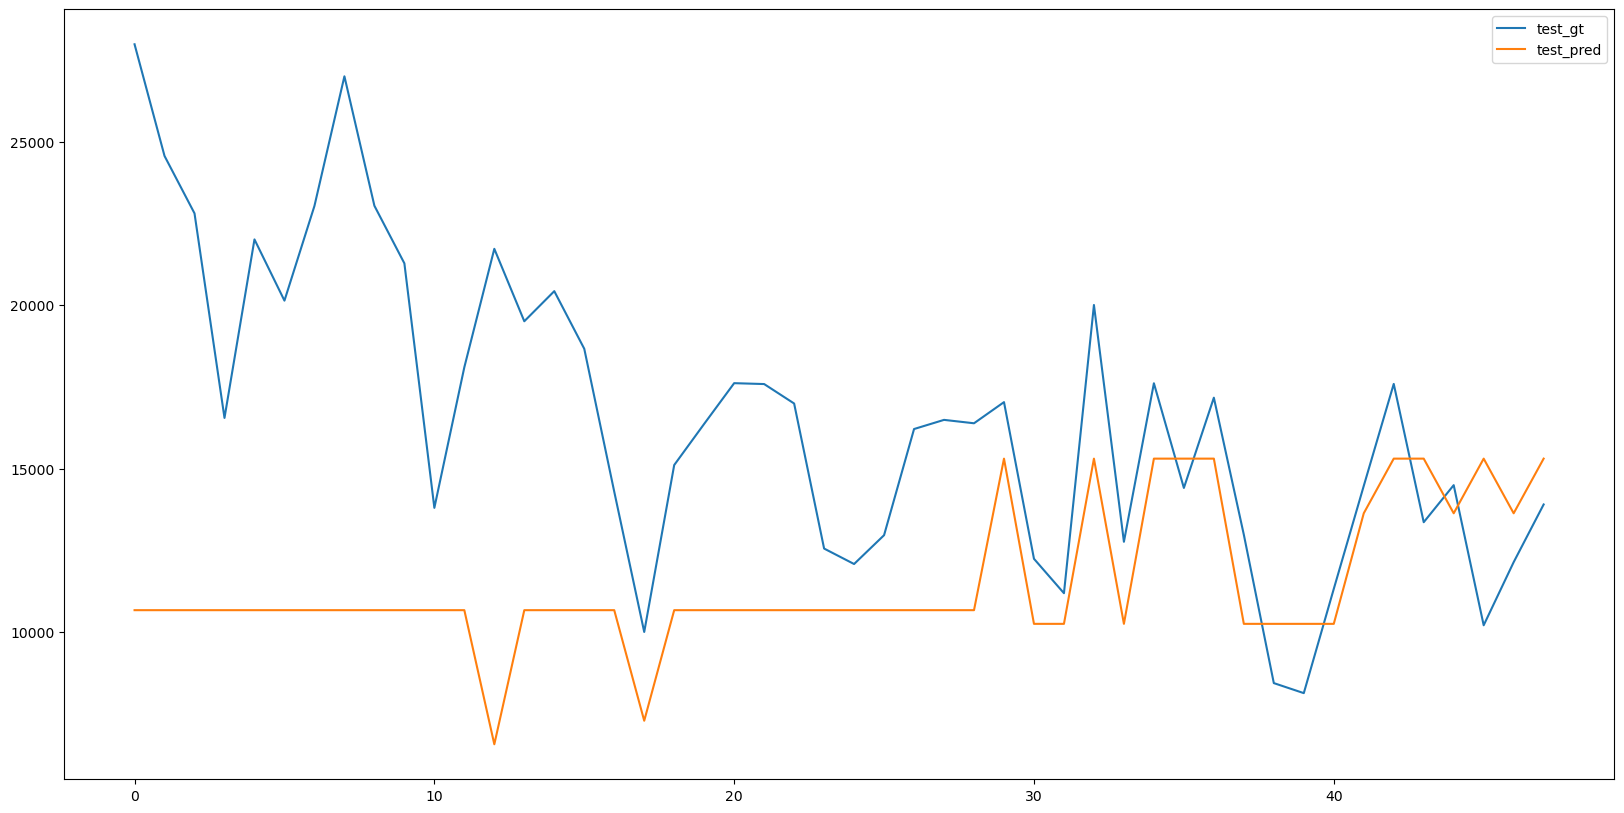

In [450]:
# Visualizing test data fitted values
pd.concat([s_y_test, s_test_pred["yhat"]], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [451]:
# MAE on test data
mean_absolute_error(s_y_test, s_test_pred)

5666.076273600261

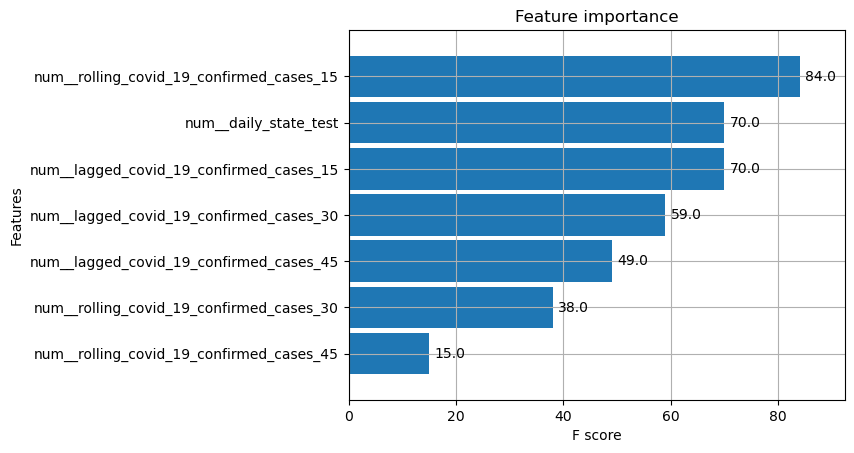

In [452]:
# Feature importance
s_feature_im = plot_importance(s_randomized_search.best_estimator_, height=0.9)